In [ ]:
# !pip install folium

In [57]:
import folium
import pandas as pd
from folium import plugins

In [60]:
mp = folium.Map(location=[-23.00079,-43.384157],
                        zoom_start=13)

In [2]:
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="CartoDB dark_matter")
marker = folium.CircleMarker(location=[40.738, -73.98])
marker.add_to(folium_map)

In [3]:
folium_map

In [ ]:
# folium_map.save("my_map.html") # exportar o mapa como uma pagina html

In [9]:
bike_data = pd.read_csv("201601-citibike-tripdata.zip")
bike_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,923,1/1/2016 00:00:41,1/1/2016 00:16:04,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958.0,1
1,379,1/1/2016 00:00:45,1/1/2016 00:07:04,476,E 31 St & 3 Ave,40.743943,-73.979661,498,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969.0,1
2,589,1/1/2016 00:00:48,1/1/2016 00:10:37,489,10 Ave & W 28 St,40.750664,-74.001768,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982.0,2
3,889,1/1/2016 00:01:06,1/1/2016 00:15:56,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961.0,2
4,1480,1/1/2016 00:01:12,1/1/2016 00:25:52,2006,Central Park S & 6 Ave,40.765909,-73.976342,2006,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952.0,1


In [63]:
bike_data = bike_data.sample(10000)

In [64]:
bike_data["starttime"] = pd.to_datetime(bike_data["starttime"])
bike_data["stoptime"] = pd.to_datetime(bike_data["stoptime"])
bike_data["hour"] = bike_data["starttime"].map(lambda x: x.hour)

In [65]:
bike_data.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'hour', 'path_id'],
      dtype='object')

In [66]:
# select the first occurrence of each station id
locations = bike_data.groupby("start station id").first()
# and select only the tree columns we are interested in
locations = locations.loc[:, ["start station latitude",
                              "start station longitude",
                              "start station name"]]

In [67]:
bike_data["hour"].value_counts().head()

17    950
18    922
8     886
16    763
9     696
Name: hour, dtype: int64

In [68]:
selected_hour = 17
subset = bike_data[bike_data["hour"]==selected_hour]
departure_counts =  subset.groupby("start station id").count()

# select one column
departure_counts = departure_counts.iloc[:,[0]]

# and rename that column
departure_counts.columns= ["Departure Count"]

In [69]:
arrival_counts = subset.groupby('end station id').count()
arrival_counts = arrival_counts.iloc[:,[0]]
arrival_counts.columns= ["Arrival Count"]

In [33]:
trip_counts = departure_counts.join(locations).join(arrival_counts)

In [35]:
for index, row in trip_counts.iterrows():
    net_departures = (row["Departure Count"]-row["Arrival Count"])
    radius = net_departures/20
    
    if net_departures>0:
        color="#E37222" # tangerine
    else:
        color="#0A8A9F" # teal
    
    folium.CircleMarker(location=(row["start station latitude"],
                                  row["start station longitude"]),
                        radius=radius,
                        color=color,
                        fill=True).add_to(folium_map)

In [36]:
folium_map

# plotando as rotas

In [38]:
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
import scipy.ndimage.filters

In [70]:
def get_kernel(kernel_size, blur=1/20, halo=.001):
    """
    Create an (n*2+1)x(n*2+1) numpy array.
    Output can be used as the kernel for convolution.
    """
    
    # generate x and y grids
    x, y = np.mgrid[0:kernel_size*2+1, 0:kernel_size*2+1]
    
    center = kernel_size + 1  # center pixel
    r = np.sqrt((x - center)**2 + (y - center)**2)  # distance from center
    
    # now compute the kernel. This function is a bit arbitrary. 
    # adjust this to get the effect you want.
    kernel = np.exp(-r/kernel_size/blur) + (1 - r/r[center,0]).clip(0)*halo
    return kernel

def add_lines(image_array, xys, width=1, weights=None):
    """
    Add a set of lines (xys) to an existing image_array
    width: width of lines
    weights: [], optional list of multipliers for lines. 
    """
    
    for i, xy in enumerate(xys):  # loop over lines
        # create a new gray scale image
        image = Image.new("L",(image_array.shape[1], image_array.shape[0]))
        
        # draw the line
        ImageDraw.Draw(image).line(xy, 200, width=width)
        
        #convert to array
        new_image_array = np.asarray(image, dtype=np.uint8).astype(float)
        
        # apply weights if provided
        if weights is not None:
            new_image_array *= weights[i]
            
        # add to existing array
        image_array += new_image_array

    # convolve image
    new_image_array = scipy.ndimage.filters.convolve(image_array, get_kernel(width*4)) 
    return new_image_array


def to_image(array, hue=.62):
    """converts an array of floats to an array of RGB values using a colormap"""
    
    # apply saturation function
    image_data = np.log(array + 1)
    
    # create colormap, change these values to adjust to look of your plot
    saturation_values = [[0, 0], [1, .68], [.78, .87], [0, 1]]
    colors = [hsv_to_rgb([hue, x, y]) for x, y in saturation_values]
    cmap = LinearSegmentedColormap.from_list("my_colormap", colors)
    
    # apply colormap
    out = cmap(image_data/image_data.max())
    
    # convert to 8-bit unsigned integer
    out = (out*255).astype(np.uint8)
    return out

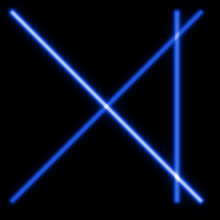

In [71]:
xys = [(10,10,200,200), (175,10,175,200), (200,10,10,200)]  # some lines
weights = np.array([ 2,1,.7])/100  # some weights

# create the image_data
new_image_data = add_lines(np.zeros((220,220)),
                           xys,
                           width=4,
                           weights=weights) 

# show the image
Image.fromarray(to_image(new_image_data),mode="RGBA")

In [41]:
min_lat = bike_data["start station latitude"].min()
max_lat = bike_data["start station latitude"].max()
max_lon = bike_data["start station longitude"].max()
min_lon = bike_data["start station longitude"].min()

def latlon_to_pixel(lat, lon, image_shape):
    # longitude to pixel conversion (fit data to image)
    delta_x = image_shape[1]/(max_lon-min_lon)
    
    # latitude to pixel conversion (maintain aspect ratio)
    delta_y = delta_x/np.cos(lat/360*np.pi*2)
    pixel_y = (max_lat-lat)*delta_y
    pixel_x = (lon-min_lon)*delta_x
    return (pixel_y,pixel_x)


def row_to_pixel(row,image_shape):
    """
    convert a row (1 trip) to pixel coordinates
    of start and end point
    """
    start_y, start_x = latlon_to_pixel(row["start station latitude"], 
                                       row["start station longitude"], image_shape)
    end_y, end_x = latlon_to_pixel(row["end station latitude"], 
                                   row["end station longitude"], image_shape)
    xy = (start_x, start_y, end_x, end_y)
    return xy

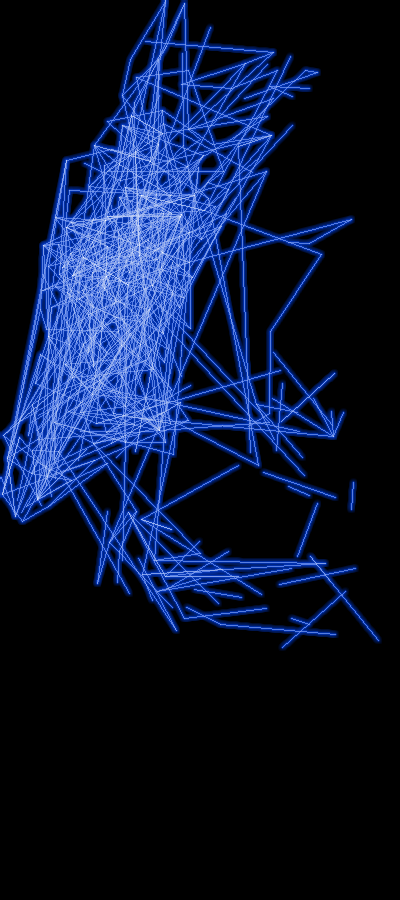

In [46]:
paths = bike_data[bike_data.hour==9]
paths = paths.iloc[:3000,:]

# generate empty pixel array, choose your resolution
image_data = np.zeros((900,400))

# generate pixel coordinates of starting points and end points
xys = [row_to_pixel(row, image_data.shape) for i, row in paths.iterrows()]

# draw the lines
image_data = add_lines(image_data, xys, weights=None, width = 1)
Image.fromarray(to_image(image_data*10)[:,:,:3],mode="RGB")

In [52]:
# make a list of locations (latitude longitude) for each station id
locations = bike_data.groupby("start station id").mean()
locations = locations.loc[:,["start station latitude", "start station longitude"]]

# group by each unique pair of (start-station, end-station) and count the number of trips
bike_data["path_id"] = [(id1,id2) for id1,id2 in zip(bike_data["start station id"], 
                                                     bike_data["end station id"])]

paths = bike_data[bike_data["hour"]==9].groupby("path_id").count().iloc[:,[1]] 
paths.columns = ["Trip Count"]

# select only paths with more than X trips
paths = paths[paths["Trip Count"]>0]
paths["start station id"] = paths.index.map(lambda x:x[0])
paths["end station id"] = paths.index.map(lambda x:x[1])
paths = paths[paths["start station id"]!=paths["end station id"]]

# join latitude/longitude into new table
paths = paths.join(locations,on="start station id")
locations.columns = ["end station latitude","end station longitude"]
paths = paths.join(locations,on="end station id")
paths.index = range(len(paths))

paths.shape

(656, 7)

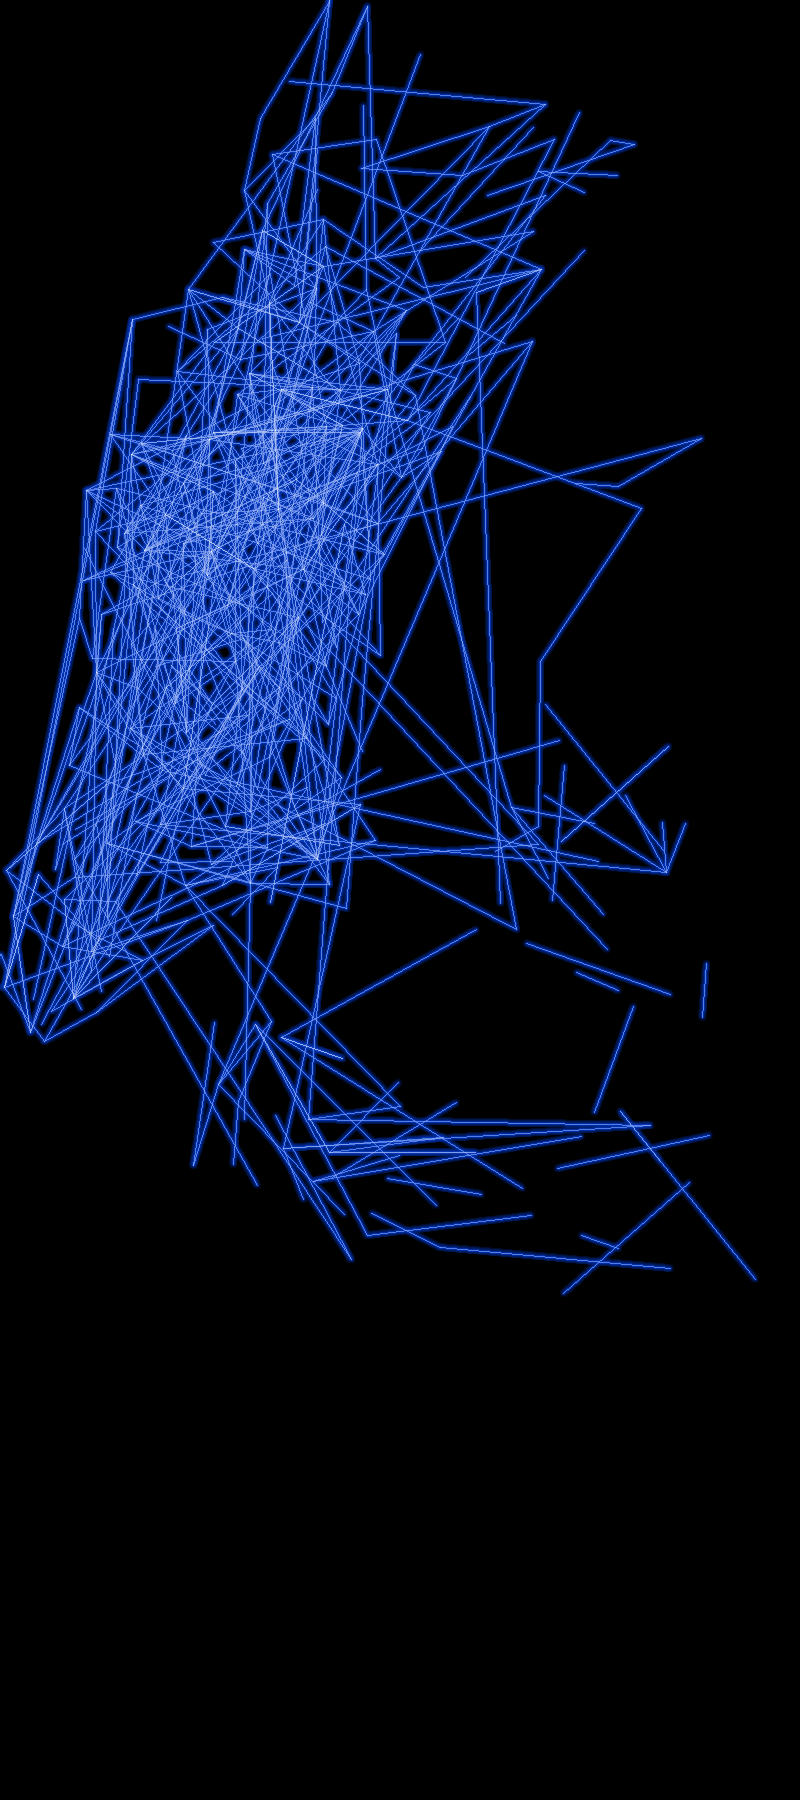

In [53]:
def get_image_data(paths, min_count=0, max_count=None):
    # generate empty pixel array
    image_data = np.zeros((900*2,400*2))
    
    # generate pixel coordinates of starting points and end points
    if max_count is None:
        max_count = paths["Trip Count"].max()+1
    selector = (paths["Trip Count"]>= min_count) & (paths["Trip Count"]< max_count)
    xys = [row_to_pixel(row, image_data.shape) for i, row in paths[selector].iterrows()]

    # draw the lines
    image_data = add_lines(image_data, xys, weights=paths["Trip Count"], width = 1)
    return image_data

Image.fromarray(to_image(get_image_data(paths)*10)[:,:,:3],mode="RGB")

In [54]:
def add_alpha(image_data):
    """
    Uses the Value in HSV as an alpha channel. 
    This creates an image that blends nicely with a black background.
    """
    
    # get hsv image
    hsv = rgb_to_hsv(image_data[:,:,:3].astype(float)/255)
    
    # create new image and set alpha channel
    new_image_data = np.zeros(image_data.shape)
    new_image_data[:,:,3] = hsv[:,:,2]
    
    # set value of hsv image to either 0 or 1.
    hsv[:,:,2] = np.where(hsv[:,:,2]>0, 1, 0)
    
    # combine alpha and new rgb
    new_image_data[:,:,:3] = hsv_to_rgb(hsv)
    return new_image_data

In [55]:
# create the map
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="CartoDB dark_matter",
                        width='50%')

# create the overlay
map_overlay = add_alpha(to_image(image_data*10))

# compute extent of image in lat/lon
aspect_ratio = map_overlay.shape[1]/map_overlay.shape[0]
delta_lat = (max_lon-min_lon)/aspect_ratio*np.cos(min_lat/360*2*np.pi)

# add the image to the map
img = folium.raster_layers.ImageOverlay(map_overlay,
                           bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)],
                           opacity = 1,
                           name = "Paths")

img.add_to(folium_map)
folium.LayerControl().add_to(folium_map)

# show the map
folium_map

fonte: https://nbviewer.jupyter.org/github/vincentropy/python_cartography_tutorial/blob/master/part2_custom_layers.ipynb